In [1]:
import os
os.chdir('/home/megatron/work')

import megatron
import pandas as pd
import numpy as np

In [2]:
lahman = pd.read_csv('data/lahman/core/Batting.csv')

In [3]:
pd.set_option('display.max_columns', 500)
lahman.tail()

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
104319,zimmejo02,2017,1,DET,AL,29,6,0,1,0,0,0,0.0,0.0,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0
104320,zimmery01,2017,1,WAS,NL,144,524,90,159,33,0,36,108.0,1.0,0.0,44,126.0,1.0,3.0,0.0,5.0,16.0
104321,zobribe01,2017,1,CHN,NL,128,435,58,101,20,3,12,50.0,2.0,2.0,54,71.0,2.0,2.0,2.0,3.0,13.0
104322,zuninmi01,2017,1,SEA,AL,124,387,52,97,25,0,25,64.0,1.0,0.0,39,160.0,0.0,8.0,0.0,1.0,8.0
104323,zychto01,2017,1,SEA,AL,45,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
P = megatron.Pipeline()
inputs = megatron.adapters.input.from_dataframe(lahman, P)

new_types = [np.str, np.int, np.int, np.str, np.str] + [np.int]*17

fillna = megatron.layers.Impute({np.nan: 0}, name='fillna')
inputs = fillna(inputs)

for new_type, name in zip(new_types, inputs.names):
    inputs[name] = megatron.layers.Retype(new_type)(inputs[name])

# helpers
def single_fn(h, d, t, hr):
    return h - d - t - hr
singles = megatron.layers.Lambda(single_fn, name='Singles')(inputs[['H','2B','3B','HR']])
hit_types = megatron.layers.Concatenate('hit_types')([singles] + inputs[['2B','3B','HR']])
TB = megatron.layers.Dot(W=np.array([1,2,3,4]), name='TB')(hit_types)

# basics
PA = megatron.layers.Add(name='PA')(inputs[['AB', 'BB', 'HBP', 'SH', 'SF']])
BBp = megatron.layers.Divide(name='BB%')([inputs['BB'], PA])
Kp = megatron.layers.Divide(name='K%')([inputs['SO'], PA])
def obp(h, bb, hbp, ab, sf):
    return megatron.utils.safe_divide(h + bb + hbp, ab + bb + hbp + sf)
OBP = megatron.layers.Lambda(obp, name='OBP')(inputs[['H','BB','HBP','AB','SF']])
OBP = fillna(OBP)
SLG = megatron.layers.Divide(name='SLG')([TB, inputs['AB']])
AVG = megatron.layers.Divide(name='AVG')(inputs[['H', 'AB']])
ISO = megatron.layers.Subtract(name='ISO')([SLG, AVG])
def babip(h, hr, ab, k, sf):
    return megatron.utils.safe_divide(h - hr, ab - k - hr + sf)
BABIP = megatron.layers.Lambda(babip, name='BABIP')(inputs[['H','HR','AB','SO','SF']])
BABIP = fillna(BABIP)

out = P.run([PA, BBp, Kp, OBP, SLG, AVG, ISO, BABIP], lahman,
            cache_result=True, form='dataframe')

In [5]:
out = P.run([PA, BBp, Kp, OBP, SLG, AVG, ISO, BABIP], lahman,
            cache_result=True, form='dataframe')

Loading node named 'PA' from cache
Loading node named 'BB%' from cache
Loading node named 'K%' from cache
Loading node named 'fillna' from cache
Loading node named 'SLG' from cache
Loading node named 'AVG' from cache
Loading node named 'ISO' from cache
Loading node named 'fillna' from cache


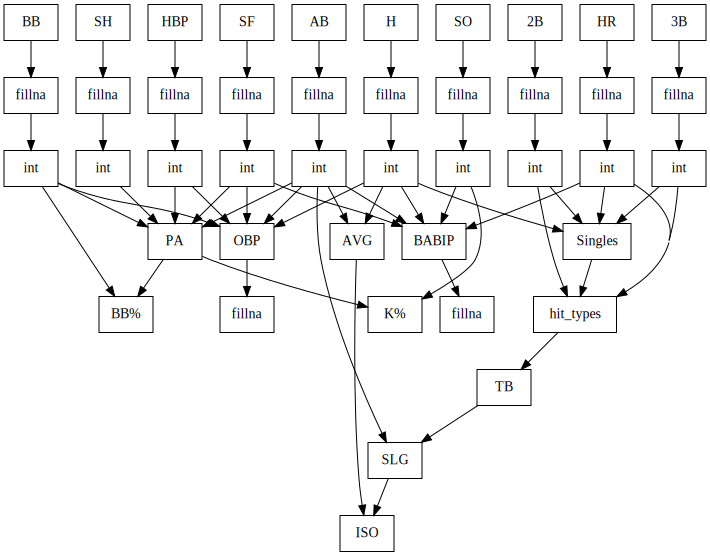

In [6]:
megatron.visuals.pipeline_imshow(P, [BBp, Kp, OBP, SLG, AVG, ISO, BABIP])